In [ ]:
########################################################################################################################
# Filename: Text_Preprocessing.ipynb
#
# Purpose: Preprocess text data using both bag-of-words and sequence of integers approaches.
#
# Author(s): Bobby (Robert) Lumpkin
#
# Library Dependencies: numpy, pandas, tensorflow, bpmll, scipy, random, os, re, string, json, collections, 
#                       sklearn, nltk, 
#
# NOTES: (1) A lot of the data cleaning performed here is due to a great tutorial written by Patrick Loeber
#        which can be found at: https://github.com/python-engineer/tensorflow-course/blob/master/11_NLP.ipynb
#        (2) The code organizing the Reuters-21578 dataset into a pandas dataframe came from Kaggle
#        and can be found at: https://www.kaggle.com/boldy717/reutersnltk
########################################################################################################################

# Text Preprocessing for Multilabel Classification

In [1]:
from scipy.io import arff
import random
import os
import re
import string
import numpy as np
import json
import pandas as pd
from collections import Counter
from bpmll import bp_mll_loss
import sklearn_json as skljson
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import reuters    ## This downloads the reduced Reuters-21578 dataset
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
from transformers import TFAutoModel
import tensorflow as tf
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

## Loading the Reuters-21578 Dataset

In [2]:
reuters.words('training/9865')[:14]

['FRENCH',
 'FREE',
 'MARKET',
 'CEREAL',
 'EXPORT',
 'BIDS',
 'DETAILED',
 'French',
 'operators',
 'have',
 'requested',
 'licences',
 'to',
 'export']

In [3]:
reuters.categories('training/9865')

['barley', 'corn', 'grain', 'wheat']

In [4]:
# Extract fileids from the reuters corpus
fileids = reuters.fileids()

# Initialize empty lists to store categories and raw text
categories = []
text = []

# Loop through each file id and collect each files categories and raw text
for file in fileids:
    categories.append(reuters.categories(file))
    text.append(reuters.raw(file))

# Combine lists into pandas dataframe. reutersDf is the final dataframe. 
reutersDF = pd.DataFrame({'ids':fileids, 'categories':categories, 'text':text})

In [5]:
reutersDF.head()

,ids,categories,text
0,test/14826,[trade],ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...
1,test/14828,[grain],CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...
2,test/14829,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...
3,test/14832,"[corn, grain, rice, rubber, sugar, tin, trade]",THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n ...
4,test/14833,"[palm-oil, veg-oil]",INDONESIA SEES CPO PRICE RISING SHARPLY\n Ind...


## Data Cleaning

In [6]:
## Check if there are any urls in articles
pattern = re.compile(r"https?://(\S+|www)\.\S+")
for t in reutersDF.text:
    matches = pattern.findall(t)
    for match in matches:
        print(t)
        print(match)
        print(pattern.sub(r"", t))
    if len(matches) > 0:
        break

In [7]:
## Define a function to remove punctuation from documents
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
## Remove punctuation from documents
reutersDF["text"] = reutersDF.text.apply(remove_punct)

In [9]:
# Define a function to remove stopwords
nltk.download('stopwords')

# Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine
# has been programmed to ignore, both when indexing entries for searching and when retrieving them 
# as the result of a search query.
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
## Remove stopwords
reutersDF["text"] = reutersDF.text.apply(remove_stopwords)

In [11]:
## Generate binary labels from 'categories'
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(reutersDF.categories)
labelsDF = pd.DataFrame(binary_labels, columns = mlb.classes_)
labels_array = labelsDF.to_numpy()

reutersDF = pd.concat([reutersDF, labelsDF], axis = 1)
reutersDF.head()

,ids,categories,text,acq,alum,barley,bop,carcass,castor-oil,cocoa,...,sun-oil,sunseed,tea,tin,trade,veg-oil,wheat,wpi,yen,zinc
0,test/14826,[trade],asian exporters fear damage usjapan rift mount...,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,test/14828,[grain],china daily says vermin eat 712 pct grain stoc...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,test/14829,"[crude, nat-gas]",japan revise longterm energy demand downwards ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,test/14832,"[corn, grain, rice, rubber, sugar, tin, trade]",thai trade deficit widens first quarter thaila...,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,test/14833,"[palm-oil, veg-oil]",indonesia sees cpo price rising sharply indone...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Save the label list
label_list = list(reutersDF.columns[3:])
label_list_dict = {'label_list' : label_list}
#with open("Data/label_list.json", "w") as outfile: 
#    json.dump(label_list, outfile)

## Generating Features for BERT

In [12]:
## Train/Test split
reutersTrain_df = reutersDF[reutersDF.ids.str.contains('training')]
training_indices = reutersTrain_df.index
reutersTest_df = reutersDF[reutersDF.ids.str.contains('test')]
test_indices = reutersTest_df.index
labelsTrain_array = labels_array[training_indices]
labelsTest_array = labels_array[test_indices]

In [13]:
%%capture
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

The max doc length is: 1506


<AxesSubplot:xlabel='text', ylabel='Count'>

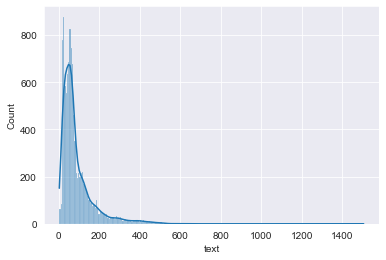

In [14]:
seqlen = reutersDF['text'].apply(lambda x: len(x.split()))
max_doc_length = 0
for doc in reutersDF['text']:
    if len(doc.split()) > max_doc_length:
        max_doc_length = len(doc.split())
        
max_length = max_doc_length

print(f"The max doc length is: {max_length}")
sns.histplot(seqlen, kde = True)

In [15]:
Xids_Train = np.zeros((len(reutersTrain_df), max_length))
Xids_Test = np.zeros((len(reutersTest_df), max_length))
Xmasks_Train = np.zeros((len(reutersTrain_df), max_length))
Xmasks_Test = np.zeros((len(reutersTest_df), max_length))

In [16]:
for i, sequence in enumerate(reutersTrain_df.text):
    tokens = tokenizer.encode_plus(sequence, 
                                   max_length = max_length, 
                                   truncation = True, 
                                   padding = 'max_length', 
                                   add_special_tokens = True, 
                                   return_token_type_ids = False, 
                                   return_attention_mask = True, 
                                   return_tensors = 'tf')
    Xids_Train[i, :], Xmasks_Train[i, :] = tokens['input_ids'], tokens['attention_mask']
    
for i, sequence in enumerate(reutersTest_df.text):
    tokens = tokenizer.encode_plus(sequence, 
                                   max_length = max_length, 
                                   truncation = True, 
                                   padding = 'max_length', 
                                   add_special_tokens = True, 
                                   return_token_type_ids = False, 
                                   return_attention_mask = True, 
                                   return_tensors = 'tf')
    Xids_Test[i, :], Xmasks_Test[i, :] = tokens['input_ids'], tokens['attention_mask']

In [23]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Write the training and test data to a .npz file
outfile = "../Data/bert_data.npz"
np.savez_compressed(outfile, Xids_Train = Xids_Train, 
                             Xids_Test = Xids_Test, 
                             Xmasks_Train = Xmasks_Train, 
                             Xmasks_Test = Xmasks_Test, 
                             labelsTrain_array = labelsTrain_array, 
                             labelsTest_array = labelsTest_array)

In [17]:
def map_func(input_ids, masks, labels):
    return {'input_ids' : input_ids, 'attention_mask' : masks}, labels

train = tf.data.Dataset.from_tensor_slices((Xids_Train, Xmasks_Train, labelsTrain_array))
test = tf.data.Dataset.from_tensor_slices((Xids_Test, Xmasks_Test, labelsTest_array))

train = train.map(map_func)
test = test.map(map_func)

## Generating TF-IDF Feature Vectors

In [13]:
## Generate tf-idf vectors for each instance
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(reutersDF.text.tolist())
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
tf_idf_DF = pd.DataFrame(dense, columns = feature_names)

In [14]:
## Split the training/test data 
label_cols = reutersDF.columns[3:]
X_tfidf = dense
Y_tfidf = reutersDF[label_cols].to_numpy()

training_indices = [index for index in reutersDF.index if 'training' in reutersDF.loc[index,].ids]
test_indices = [index for index in reutersDF.index if 'test' in reutersDF.loc[index,].ids]

X_tfidfTrain = X_tfidf[training_indices,]
X_tfidfTest = X_tfidf[test_indices]
Y_tfidfTrain = Y_tfidf[training_indices]
Y_tfidfTest = Y_tfidf[test_indices]

In [15]:
## Check to make sure there are no rows that don't have any associated labels
Y_gz = Y_tfidf > 0
no_labels_id = np.where(~Y_gz.any(axis=1))[0]
no_labels_id

array([], dtype=int64)

In [15]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Write the training and test data to a .npz file
outfile = "../Data/tfidf_trainTest_data.npz"
#np.savez_compressed(outfile, X_tfidfTrain = X_tfidfTrain, 
#                             X_tfidfTest = X_tfidfTest, 
#                             Y_tfidfTrain = Y_tfidfTrain, 
#                             Y_tfidfTest = Y_tfidfTest,
#                             feature_names = feature_names)
#feature_names

## Generating Sequence of Integers Feature Vectors (for RNNs)

In [15]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(reutersDF.text)
num_unique_words = len(counter)
print(counter.most_common(5))
print(num_unique_words)

[('said', 25376), ('mln', 18598), ('vs', 14340), ('dlrs', 12326), ('pct', 9771)]
51028


In [16]:
## Convert text column to numpy array and train/test split
X_seq = reutersDF.text.to_numpy()
X_seqTrain = X_seq[training_indices, ]
X_seqTest = X_seq[test_indices, ]

In [17]:
## Tokenize and vectorize, turning each text into a sequence of integers
random.seed(123)

tokenizer = Tokenizer(num_words = num_unique_words)
tokenizer.fit_on_texts(X_seqTrain)    # Fit only to training
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_seqTrain)
test_sequences = tokenizer.texts_to_sequences(X_seqTest)

print(X_seqTrain[0])
print(train_sequences[0])

bahia cocoa review showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review dry period means temporao late year arrivals week ended february 22 155221 bags 60 kilos making cumulative total season 593 mln 581 stage last year seems cocoa delivered earlier consignment included arrivals figures comissaria smith said still doubt much old crop cocoa still available harvesting practically come end total bahia crop estimates around 64 mln bags sales standing almost 62 mln hundred thousand bags still hands farmers middlemen exporters processors doubts much cocoa would fit export shippers experiencing dificulties obtaining bahia superior certificates view lower quality recent weeks farmers sold good part cocoa held consignment comissaria smith said spot bean prices rose 340 350 cruzados per arroba 15 kilos bean shippers reluctant offer nearby shipment

In [18]:
## Pad the sequences to have the same length (Max number of words in a sequence)
max_doc_length = 0
for doc in train_sequences:
    if len(doc) > max_doc_length:
        max_doc_length = len(doc)
        
max_length = max_doc_length

train_padded = pad_sequences(train_sequences, maxlen = max_length, padding = "post", truncating = "post")
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = "post", truncating = "post")
train_padded.shape, test_padded.shape

((7769, 827), (3019, 827))

In [20]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Write the training and test data to a .npz file
outfile = "../Data/seq_trainTest_data.npz"
#np.savez_compressed(outfile, train_padded = train_padded, 
#                             test_padded = test_padded, 
#                             Y_train = Y_tfidfTrain, 
#                             Y_test = Y_tfidfTest, 
#                             num_unique_words = num_unique_words)